# Basic analytical GGOR solution, steady state

@TO 2020-10-05

The GGOR-application dynamically simulates the groundwater head $h$ [L] and flow in an arbitrary number of the cross sections between ditches in a shallow aquifer above a regional aquifer with uniform head $\phi$ [L] separated by a confining bed with hydraulic ressistance $c$ [T]. Each cross section represents a an agricultural parcel bounded by ditches in which the water level is managed. Each parcel has its own half-width $b$ [L], other properties like horizontal conductivity $k$ [L/T], thickness $D$ [L] and ditch level $h_{LR}$ [L], yet the ditch level is the same at both sides. Therefore, only half of each cross section needs to be simulated. The exchange between the (shallow) aquifer and the ditches is across a ditch-resistance w [T] that will generally differ between infiltration ($w_i$) and exfiltration ($w_o$). The parcels receive net recharge $N$ [L/T].

The governing differential equation for steadh flow in the shallow aquifer then is
$$\frac{d}{dx}\left(kD\frac{dh}{dx}\right) = -N + \frac{h-\phi}{c}$$
With uniform transmissivity $kD$ [L$^2$/T] and introducing the spreading or characteristic length $\lambda = \sqrt{kDc}$ [L] this reduces to
$$\frac{d^2h}{dx^2}=-\frac{N}{kD}+\frac{h-\phi}{\lambda^2}$$
With the same head $h_{LR}$ on both ends the solution will be symmetrical yielding
$$h - \phi = Nc + A \cosh \frac {x}{\lambda}$$
In which the integration constant has to be solved from the boundary contion at the ditch. An exchange with the ditch through a resistance can be formulated as
$$(h_b - h_{LR})\frac{D}{w} = -kD\left(\frac{dh}{dx}\right)_{x=b}$$
or
$$h_b = h_{LR} - w \frac{k}{\lambda}A\sinh\frac{b}{\lambda}$$
which yields after some reworking
$$h-\phi = Nc - \frac{b}{\lambda}\left(Nc - \left(h_{LR}-\phi\right)\right)\Lambda
\left(\frac{\cosh\frac x \lambda}{\sinh\frac b \lambda}\right)$$
with
$$\Lambda=\frac{1}{\frac{b}{\lambda}\mbox{ctanh}\frac{b}{\lambda}+\frac{b/c}{D/w}}$$

In the GGOR application we'll work with the cross-section averaged water table most of the time. It is obtained by integrating over the width of the cross section and dividing by the width

$$\overline h - \phi = Nc - \frac{b}{\lambda}\left(Nc - \left(h_{LR}-\phi\right)\right)\Lambda\frac{1}{b}\intop_{0}^{b}\frac{\cosh\frac{x}{\lambda}}{\sinh\frac{b}{\lambda}}dx$$

$$\overline h - \phi = Nc - \frac{b}{\lambda}\left(Nc - \left(h_{LR}-\phi\right)\right)\Lambda\frac{\lambda}{b}$$

$$\overline h - \phi = Nc - \left(Nc - \left(h_{LR}-\phi\right)\right)\Lambda$$

In [140]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import pdb

In [158]:
matplotlib.rc('font', size=10)

# paths
GGOR = os.path.expanduser("~/GRWMODELS/python/GGOR")
ANALYTIC = os.path.join(GGOR, 'src', 'analytic') 
HOME = os.path.join(GGOR, 'jupyter')
sys.path.insert(0, ANALYTIC)
sys.path.insert(0, GGOR)

import ggor_analytical as ga

### Required data

#### Properties
b, k, D, c, w
#### Boundaries
phi, hlr, N

## Data for the examples in this notebook

In [159]:
columns = ['b', 'k', 'D', 'c', 'w', 'phi', 'hlr', 'N']

# Testdata, only the resistance c and the ditch resistance w vary in these data
test_data = [   [75., 10., 15.,  0.15,  1., -0.5, 0., 0.02],
                [75., 10., 15.,  1.50,  1., -0.5, 0., 0.02],
                [75., 10., 15.,  15.0,  1., -0.5, 0., 0.02],
                [75., 10., 15.,  150.,  1., -0.5, 0., 0.02],
                [75., 10., 15.,  1500,  1., -0.5, 0., 0.02],
                [75., 10., 15., 15000,  1., -0.5, 0., 0.02],
                [75., 10., 15.,  150.,  0., -0.5, 0., 0.02],
                [75., 10., 15.,  150., 0.1, -0.5, 0., 0.02],
                [75., 10., 15.,  150., 1.0, -0.5, 0., 0.02],
                [75., 10., 15.,  150., 10., -0.5, 0., 0.02],
                [75., 10., 15.,  150., 100, -0.5, 0., 0.02],
                ]
# Put them in a pandas DataFrame and show them
data = pd.DataFrame(test_data, columns=columns)
data

,b,k,D,c,w,phi,hlr,N
0,75.0,10.0,15.0,0.15,1.0,-0.5,0.0,0.02
1,75.0,10.0,15.0,1.50,1.0,-0.5,0.0,0.02
2,75.0,10.0,15.0,15.00,1.0,-0.5,0.0,0.02
3,75.0,10.0,15.0,150.00,1.0,-0.5,0.0,0.02
4,75.0,10.0,15.0,1500.00,1.0,-0.5,0.0,0.02
5,75.0,10.0,15.0,15000.00,1.0,-0.5,0.0,0.02
6,75.0,10.0,15.0,150.00,0.0,-0.5,0.0,0.02
7,75.0,10.0,15.0,150.00,0.1,-0.5,0.0,0.02
8,75.0,10.0,15.0,150.00,1.0,-0.5,0.0,0.02
9,75.0,10.0,15.0,150.00,10.0,-0.5,0.0,0.02


### Show the effect of the ditch resistance $w$ on $\Lambda$

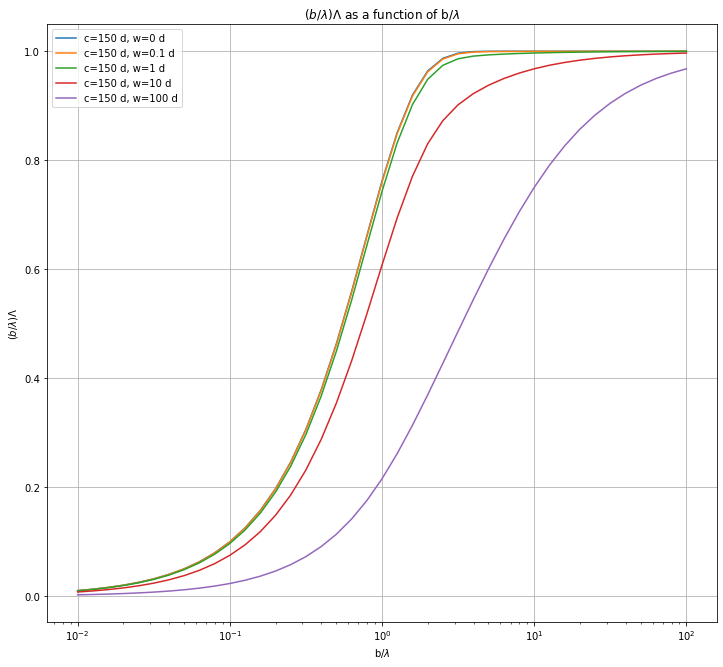

In [160]:
ax = ga.newfig('$(b/\lambda)\Lambda$ as a function of b/$\lambda$', 'b/$\lambda$', '$(b/\lambda)\Lambda$',
              xscale='log')
npoints = 41
beta = np.zeros(npoints)
Lam  = np.zeros(npoints)
for id in data.index[6:]:
    d = data.iloc[id]
    for i, blam in enumerate(np.logspace(-2, 2, npoints)):
        beta[i] = blam
        Lam[i]  = blam / (blam * np.cosh(blam) / np.sinh(blam) + (d['b'] / d['c']) / (d['D'] / d['w']))

    ax.plot(beta, Lam, label='c={:.5g} d, w={:.3g} d'.format(d['c'], d['w']))
    
ax.legend()

For any value of the ditch resistance, $\frac{b}{\lambda}\Lambda$ will vary between 0 and 1 with $\frac{b}{\lambda}$. $\frac{b}{\lambda} \downarrow 0$ implies that the parcel width will become negligible compared to the aquifer system's spreading length $\lambda$. In that case the contact with the underlying aquifer gets lost and only the ditch water level matters as boundary condition.

The experssion that remains then reduces to

$$h - \phi = Nc$$

which is, of course, correct.

With $\frac{b}{\lambda} \rightarrow \infty$, we see that $\frac{b}{\lambda}\Lambda \uparrow 1$. This is the case when the width of the parcel is much larger than the spreading lenght. In that case the ditches will no longer play any role in the solution. The remaining expression

$$h-\phi = Nc - \frac{b}{\lambda}\left(Nc - \left(h_{LR}-\phi\right)\right)\Lambda
\left(\frac{\cosh\frac x \lambda}{\sinh\frac b \lambda}\right)$$
with
$$\Lambda=\frac{1}{\frac{b}{\lambda}\mbox{ctanh}\frac{b}{\lambda}+\frac{b/c}{D/w}}$$

### Show the effect of $c$ on $\Lambda$ (i.e. $\Lambda$ as a function of $b/\lambda$)

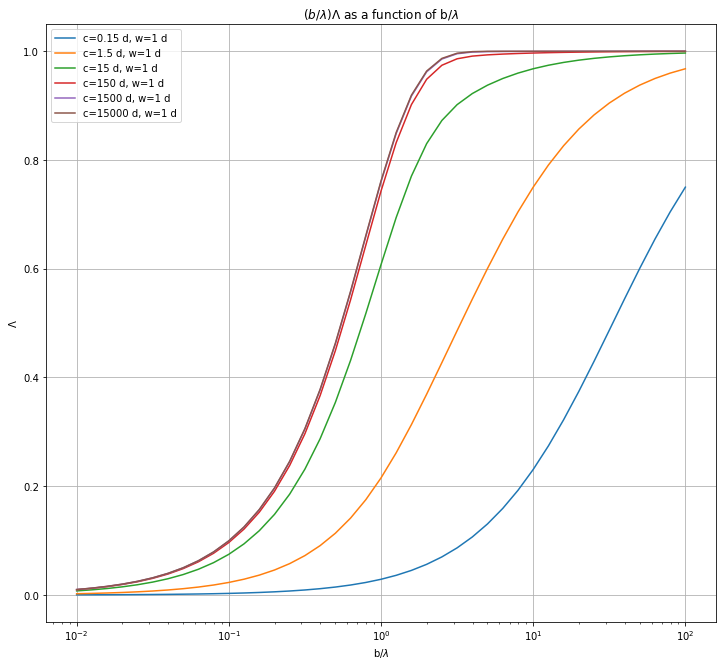

In [161]:
ax = ga.newfig('$(b/\lambda)\Lambda$ as a function of b/$\lambda$', 'b/$\lambda$', '$\Lambda$',
              xscale='log')
npoints = 41
beta = np.zeros(npoints)
Lam  = np.zeros(npoints)
for id in data.index[:6]:
    d = data.iloc[id]
    for i, blam in enumerate(np.logspace(-2, 2, npoints)):
        beta[i] = blam
        Lam[i]  = blam / (blam * np.cosh(blam) / np.sinh(blam) + (d['b'] / d['c']) / (d['D'] / d['w']))

    ax.plot(beta, Lam, label='c={:.5g} d, w={:.3g} d'.format(d['c'], d['w']))
    
ax.legend()

### Show $h(x)$ voor various $c$ and compare with the analytical solution for the case without a regional aquifer

#### First derive the solution for the case without a regional aquifer
The partial differential equation for the same situation but without a regional aquifer, which is equivalent to $c\rightarrow\infty$ is

$$\frac{d^{2}h}{dx^{2}}=-\frac{N}{kD}$$

With $x=0$, $\frac {dh}{dx}=0, the first integration constant drops so that after integrating twise

$$h=-\frac{1}{2}\frac{N}{kD}x^{2}+C_{2}$$

Boundary condition at $x-b$ yields

$$-kD\left(\frac{dh}{dx}\right)_{x=b}=\frac{D}{w}\left(h_{b}-h_{LR}\right)$$

filling in gives

$$-kD\left(-\frac{N}{kD}b\right)=\frac{D}{w}\left(-\frac{1}{2}\frac{N}{kD}b^{2}+C_{2}-h_{LR}\right)$$

so that

$$C_{2}=\frac{Nb^{2}}{2kD}+\frac{Nb}{D}w+h_{LR}$$

and, finally

$$h-h_{LR}=\frac{N\left(b^{2}-x^{2}\right)}{2kD}+Nb\frac{w}{D}$$

We will numerically show that for $\lambda\rightarrow\infty$ this function is the same as

$$h-\phi=Nc-\frac{b}{\lambda}\frac{\left(Nc-\left(h_{LR}-\phi\right)\right)}{\frac{b}{\lambda}\frac{\cosh\frac{b}{\lambda}}{\sinh\frac{b}{\lambda}}+\frac{b/c}{D/w}}\left(\frac{\cosh\frac{x}{\lambda}}{\sinh\frac{b}{\lambda}}\right)$$

### Show the graphs together with the cross-section averages

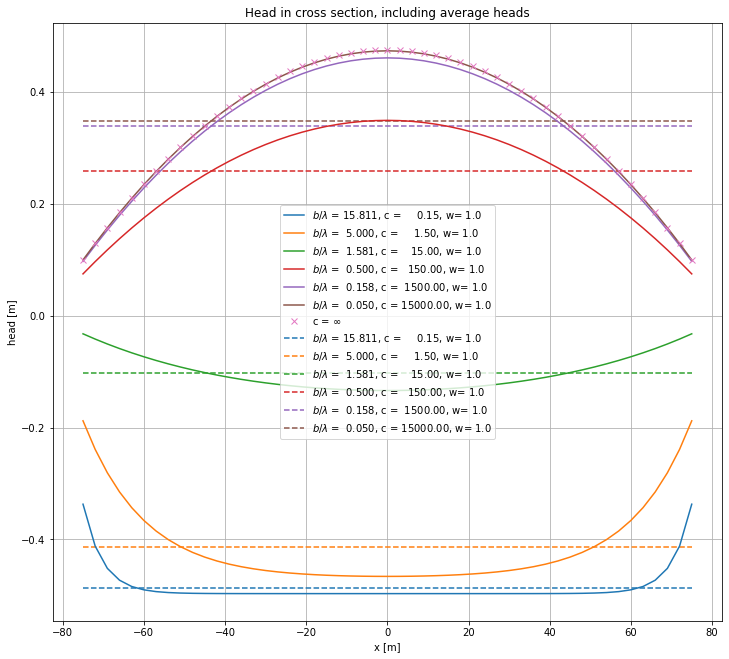

In [162]:
ax = ga.newfig('Head in cross section, including average heads', 'x [m]', 'head [m]')

for id in data.index[:6]:
    d = data.iloc[id]
    b, k, D, c, w = d['b'], d['k'], d['D'], d['c'], d['w']
    hlr, phi, N = d['hlr'], d['phi'], d['N']
    x = np.linspace(-b, b, 51)
    lam = np.sqrt(k * D * c)
    blam = b  / lam
    Lam = 1 / (blam * np.cosh(blam) / np.sinh(blam) + (b / c) / (D / w))
    
    h = phi + N * c - blam * (N * c - (hlr - phi)) * Lam * np.cosh(x / lam) / np.sinh(blam)
    label = '$b/\lambda$ = {:6.3f}, c = {:8.2f}, w={:4.1f}'.format(blam, c, w)
    hl = ax.plot(x, h, label=label)
    
    havg = phi + N * c - (N * c - (hlr - phi)) * Lam
    ax.hlines(havg, x[0], x[-1], ls='--', colors=hl[0].get_color(), label=label)
    
# The analytical solution without aquitard and underlying regional aquifer
h  = hlr + N * (b ** 2 - x ** 2) / (2 * k * D)  + N * b * w / D    
ax.plot(x, h, 'x', lw=3, label='c = $\infty$')
    
ax.legend()

The analytical solution for the situation without a regional aquifer indeed coincides with that for the case with a regional aquifer when $c\rightarrow\infty$.

The set of curves alsow show what happens when the resistance $c$ varies from very low to very high. If very low, the head in the shallow aquifer will become equal to the prescribed head in the regional aquifer except near the ditches on either side of the cross section. The greater the resistance, the smaller the influence of the deep aquifer, the more the solution will obey the recharge and the solution of the case without a regional aquifer.

### Show the effect o the wate table $h$ caused by the entry resistance $w$

The dashed lines are the cross-section averaged values.

The exact properties are given in the table above.

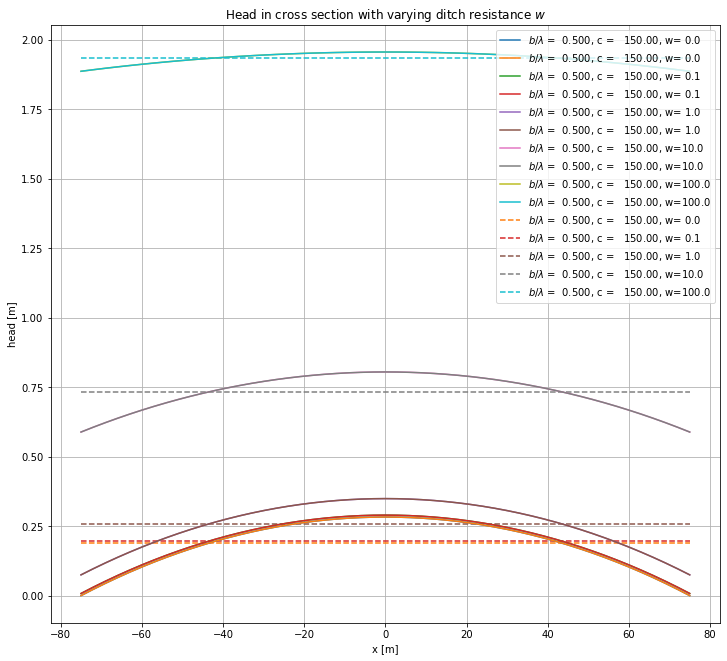

In [163]:
ax = ga.newfig('Head in cross section with varying ditch resistance $w$', 'x [m]', 'head [m]')

for id in data.index[6:]:
    d = data.iloc[id]
    b, k, D, c, w = d['b'], d['k'], d['D'], d['c'], d['w']
    hlr, phi, N = d['hlr'], d['phi'], d['N']
    x = np.linspace(-b, b, 51)
    lam = np.sqrt(k * D * c)
    blam = b / lam
    xlam = x / lam
    Lam = 1 / (blam * np.cosh(blam) / np.sinh(blam) + (b / c) / (D / w))
    
    h = phi + N * c - blam * (N * c - (hlr - phi)) * Lam * np.cosh(xlam) / np.sinh(blam)
    label = '$b/\lambda$ = {:6.3f}, c = {:8.2f}, w={:4.1f}'.format(blam, c, w)
    ax.plot(x, h, label=label)    
    
    hl = ax.plot(x, h, label=label)
    havg = phi + N * c - (N * c - (hlr - phi)) * Lam
    ax.hlines(havg, x[0], x[-1], ls='--', colors=hl[0].get_color(), label=label)

ax.legend()

Increasing the resistance between aquifer and ditch is like lifing the head parallelly. However there is still a small effect from the underlying regional aquifer, because a higher water table implies more downward leakage and less flow to the ditches.

# Transient simulation

Steady-state water balance says

$$0=N+\overline q - \overline q_b$$

When this is no longer true due to a change of one or more of the inputs, we attribute this deficit to storage

$$\mu \frac{d \overline h}{dt}=N+\overline q - \overline q_b$$

Filling in $\overline q_b$ yields

$$\mu \frac{d \overline h}{dt} = N - \frac{\overline h - \phi}{c} -
\left(N - \frac{h_{LR} - \phi}{c}\right)\Lambda$$

or

$$\mu c \frac{d \overline h}{dt} = -\left(\overline h -
\left[\phi + Nc\left(1 - \Lambda\right) + \left(h_{LR} - \phi\right) \Lambda\right]\right)
$$

or, with the so-called system characteristic time $T$

$$T = \mu c$$

we have

$$T\frac{d \overline h}{dt}=-\left(\overline h - \overline h_\infty\right)$$

with

$$\overline h_\infty = \phi + Nc\left(1 - \Lambda\right) + \left(h_{LR} - \phi\right) \Lambda$$

After integration and filling in the initial values, $\overline h = \overline h_0$ at $t=t_0$, this leads to the following dynamic relation that is valid as long as the boundaries are constant

$$\overline h - \phi = \left(\overline h_0 -\phi\right)e^{-\frac{t-t_0}{T}} +
\left[Nc\left(1 - \Lambda\right) + \left(h_{LR}-\phi\right)\Lambda\right]\left(1 - e^{-\frac{t-t_0}{T}}\right)$$

which represents the two processes that determine the groundwater head as course of time: 1) the decay towards the equilibrium without any recharge ($N=0$) and the striving towards the equilibrium $\overline h_\infty$ driven by both the recharge from precipication as that from inflow from the ditches. This basic dynamic equation alows us to simulate time series in a stepwise fashion, in which each step may be as long as the the boundaries can be assumed constant. Generally we'll simulate with daily steps, but this is not a requirement by any sense.

For the water budget components dust differentiate this equation with respect to time and multiply by the storage coefficient and noting that %T=\mu c$ plus a little rearangement so that we get the following three components of the water budget on the right-hand side that must balance the storaga: inflow from the regional aquifer, inflow recharge and outflow to the ditches:

$$\mu \frac{d\overline h}{dt} = \left[\frac{\phi - \overline h_0}{c} + N- \left(N  + \frac{\phi - h_{LR}}{c}\right)\Lambda\right] e^{-\frac{t-t_0}{T}}$$

For the true average over any time step with length $\Delta t$ we have to replace the exponent by $f$:

$$f = \left(1 - e^{-\frac{\Delta t}{T}}\right) / \frac{\Delta t}{T}$$

Hence, the average water budget components during any time step are as below, where the subscripts indicate the type of component in accordance with MODFLOW, that is, each component is positive as it add water to the considered layer. As can be seen the sum of these components is always zero. Their dimension is [L/T], i.e. average over the cross section, and their value is the exact average over the time step.

$$q_{STO} = -\mu\frac{\overline h_{t+\Delta t} - \overline h_t}{\Delta t}$$
$$q_{FLF} = \frac{\phi - h_0}{c} f$$
$$q_{RCH} = N$$
$$q_{GHB} = -\left(N  + \frac{\phi - h_{LR}}{c}\right)\Lambda f $$

In [203]:
prpcols = ['sy', 'b', 'k', 'D', 'c', 'w']

prpdata = [[0.25, 75., 10., 15.,  150.,  1.],
           [0.10, 75., 10., 15.,  150.,  1.],
           [0.05, 75., 10., 15.,  150.,  1.],
           [0.02, 75., 10., 15.,  150.,  1.],
        ]

prdcols = ['time', 'N', 'phi', 'hlr']

prddata = [['2020-01-01',  0.000, -0.5, 0.0],
           ['2020-03-01',  0.015, -0.5, 0.0],
           ['2020-06-01',  0.030, -0.5, 0.0],
           ['2020-09-01',  0.045, -0.5, 0.0],
           ['2020-12-01', -0.030, -0.5, 0.0],
           ['2021-02-01',  0.000, -0.5, 0.0],
        ]

In [204]:
propdata = pd.DataFrame(prpdata, columns=prpcols) # parcel properties
perdata  = pd.DataFrame(prddata, columns=prdcols) # stress periods

# Make index into pd.Timestamps (so use datetimes)
perdata.index = [pd.Timestamp(f) for f in perdata['time']]
perdata = perdata.drop(columns='time')

# Simulation time, real datetimes, dayly values
time = [tdata.index[0] + np.timedelta64(i, 'D') for i in range(720)]
tdata = pd.DataFrame(index=time, columns=['h', 'phi', 'hlr', 'N'])

# Dict to store water flow components à la MODDFLOW's budget file but dimension is [L/T]
# CBC['STO'][ip, it] will be the storage [m/d] of parcel ip at time it
CBC = dict()
for lbl in ['STO', 'FLF', 'RCH', 'GHB']:
    CBC[lbl] = np.zeros((len(propdata), len(tdata)))

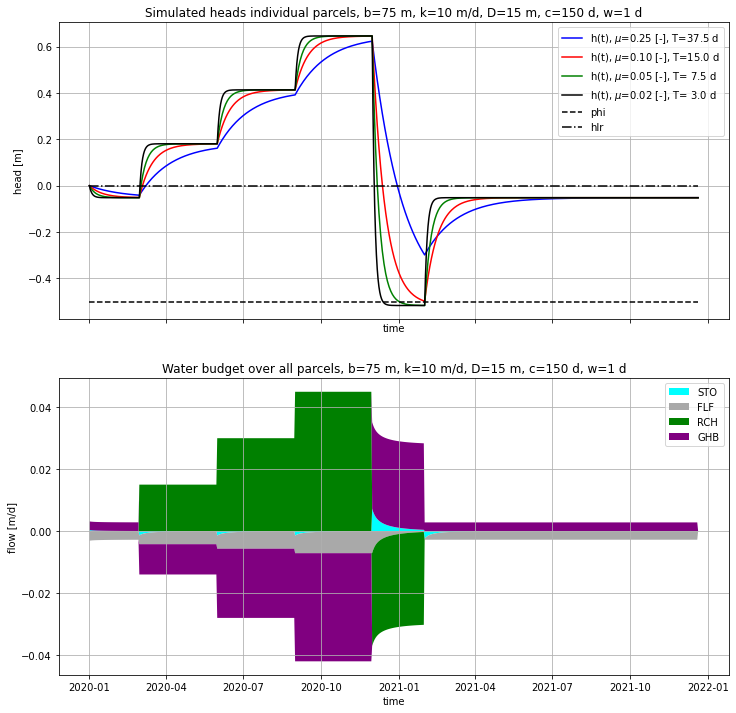

In [206]:
d = propdata.iloc[0]
ttl1 = 'Simulated heads individual parcels, b={:.0f} m, k={:.0f} m/d, D={:.0f} m, c={:.0f} d, w={:.0f} d'.format(
    d['b'], d['k'], d['D'], d['c'], d['w'])
ttl2 = 'Water budget over all parcels, b={:.0f} m, k={:.0f} m/d, D={:.0f} m, c={:.0f} d, w={:.0f} d'.format(
    d['b'], d['k'], d['D'], d['c'], d['w'])

ax = ga.newfig2([ttl1, ttl2], 'time', ['head [m]', 'flow [m/d]'], size_inches=(12,12))

clrs = ['b', 'r', 'g', 'k', 'm', 'c', 'purple', 'gray']

for ip in range(len(propdata)):
    d = propdata.iloc[ip]
    Sy, b, k, D, c, w = d['sy'], d['b'], d['k'], d['D'], d['c'], d['w']
    T = Sy * c
    lam = np.sqrt(k * D * c)
    blam = b / lam
    Lam = 1 / (blam * np.cosh(blam) / np.sinh(blam) + (b  / c) / (D  / w))

    dp = perdata.iloc[0]
    td = tdata.iloc[0]
    td[['h', 'phi', 'hlr', 'N']] = (0., dp['phi'], dp['hlr'], dp['N'])

    tprev = tdata.index[0]
    for it, t in enumerate(tdata.index[1:]):
        dt = (t - tprev) / np.timedelta64(1, 'D')
        h0 = tdata['h'].loc[tprev]
        perchange = perdata.index[perdata.index <= t][-1]
        prd  = perdata.loc[perchange]
        N, phi, hlr   = prd['N'], prd['phi'], prd['hlr']
        hinf = phi + N * c * (1 - Lam) + (hlr - phi) * Lam
        e = np.exp(-(dt) / T)
        td = tdata.loc[t]
        h = phi + (h0 - phi) * e + (hinf - phi) * (1 - e)
        td[['h','phi', 'hlr', 'N']] = h, phi, hlr, N
        
        f = (1 - e) / (dt  / T)
        CBC['STO'][ip, it] = -Sy * (h - h0) / dt
        CBC['FLF'][ip, it] = (phi - h0) / c * f
        CBC['RCH'][ip, it] = N
        CBC['GHB'][ip, it] = -(N + (phi - hlr) / c) * Lam * f
        
        tprev = t

    ax[0].plot(tdata.index, tdata['h'], color=clrs[ip % len(clrs)],
            label='h(t), $\mu$={:.2f} [-], T={:4.1f} d'.format(Sy, T))

ax[0].plot(tdata.index, tdata['phi'], 'k--', label='phi' )
ax[0].plot(tdata.index, tdata['hlr'], 'k-.', label='hlr')
ax[0].legend()

components = ['STO', 'FLF', 'RCH', 'GHB']
V = np.zeros((len(components), len(tdata)))
for ic, comp in enumerate(components):
    V[ic] = CBC[comp].mean(axis=0)

clrs = ['cyan', 'darkgray', 'green', 'purple']
ax[1].stackplot(tdata.index, V * (V > 0), labels=components, colors=clrs)
ax[1].stackplot(tdata.index, V * (V < 0), colors=clrs)
ax[1].legend()

Above zero is inflow, below zero outflow. So we start with inflow from the ditch (GHB) bcause intially the water level goes below the ditch level. The storage is present but small and, therefore, hardly visible. This inflow flows downward into the underlying regional aquifer. The recharge starts with a positive value (green).For a short time storage is visible. This recharge is drained both to the regional aquifer and towards the ditch. Ect. In the one but last period, recharge is negative, causing the ditch to infiltrate water. In the large phase, without any recharge, there is a permanent inflow from the ditch that drains to the underlying regional aquifer due to the its low and maintained head.

The water budget components of the underlying regional aquifer can also be determined, even without actually simulating it. Its storage follows from the head difference in the regional aquifer between successive times. The leakage to the upper aquifer is the inverse of the seepage into the upper aquifer. The flow from the larger environment to the regional aquifer will then be the closing factor of the water budget. We may even include the budget of ditches that cut into the regional aquifer. We would have the following components:
$$STO = - S \frac{\phi_{t + \Delta t} - \phi_t}{\Delta t}$$
$$FLF = - f\frac{\phi - \overline h_0}{c}$$
$$GHB = -\frac{f}{b}\frac{D_2}{w_2}\left(\phi - h_{LR}\right)$$
$$WEL = STO + FLF + GHB$$